# Speech MNIST
We are operating on melspectrogram features. Due to the similarity with images, we can use a CNN to classify the spoken digits.

For the data, we are going to use the following repo.

!!! Please clone this as soon as possible. It takes roughly a minute to pull from Github.

In [ ]:
!git clone https://github.com/jayrodge/AudioMNIST-using-PyTorch.git

## Mac OS
It is strongly recommended to run this task on your M series Mac as it will be quicker than Colab. The following command will install the necessary dependencies according to [Apple](https://developer.apple.com/metal/tensorflow-plugin/).

```bash
python3 -m venv ~/venv-metal
source ~/venv-metal/bin/activate
python -m pip install -U pip
python -m pip install tensorflow
python -m pip install tensorflow-metal

# other dependencies
python -m pip install matplotlib
python -m pip install numpy
python -m pip install scikit-learn
python -m pip install seaborn

# If you haven't setup jupyter
pip install notebook
```

## Importing libraries
First we are going to import the necessary libraries

In [1]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import numpy as np
from sklearn.model_selection import train_test_split

os.chdir('AudioMNIST-using-PyTorch/')

## Data Preprocessing
We are going to load the data and preprocess it. Refer to the comment for each function for more details.

In [2]:
def load_and_preprocess_image(path):
    '''
    We are going to load png images and resize them to 224x224.
    After that, we normalize the images to be in the range [-0.5, 0.5].
    '''
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = (image / 255.0) - 0.5
    return image

def get_filenames_and_labels(root_dir):
    '''
    Returns a list of filenames and a list of labels. The filenames and labels are matched.
    - Subfolders under `AudioMNIST-using-PyTorch/MNIST/` corresponds to the labels.
        - Eg. `AudioMNIST-using-PyTorch/MNIST/00/` contains all the files with label 0.
    - Labels should be integers from 0 to 9.
    '''
    filenames = []
    labels = []
    for subdir in sorted(os.listdir(root_dir)):
        subdir_path = os.path.join(root_dir, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                if filename.endswith('.png'):  # PNG format
                    filenames.append(os.path.join(subdir_path, filename))
                    labels.append(int(subdir))  # Convert subdir names directly to integers
    return filenames, labels

def split_data(filenames, labels, test_size=0.2, valid_size=0.2):
    '''
    We are going to split pairs of filenames and labels into train, test and valid sets.
        - For example, if `test_size=0.2` and `valid_size=0.2`, then 60% of the data will be used for training,
        and 20% each for testing and validation.
    - Please refer to the documentation of `train_test_split` in `sklearn.model_selection` for more information.
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    '''
    # Split into train and temp (test + valid)
    filenames_train, filenames_temp, labels_train, labels_temp = train_test_split(
        filenames, labels, test_size=(test_size + valid_size), stratify=labels, random_state=42)
    
    # Split temp into test and valid
    test_size_adjusted = test_size / (test_size + valid_size)
    filenames_test, filenames_valid, labels_test, labels_valid = train_test_split(
        filenames_temp, labels_temp, test_size=test_size_adjusted, stratify=labels_temp, random_state=42)
    
    return filenames_train, labels_train, filenames_test, labels_test, filenames_valid, labels_valid

def create_dataset(filenames, labels, batch_size=32):
    '''
    This function creates a `tf.data.Dataset` from a list of filenames and a list of labels.
    The function should work out of the box. You don't need to modify it.
    '''
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(lambda x, y: (load_and_preprocess_image(x), tf.cast(y, tf.int32)),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=2 * batch_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

## Intantiation of Datasets
Now we are actually going to call the preprocessing functions and instantiate the datasets.

In [3]:
root_dir = 'MNIST'
batch_size = 64

# Get filenames and labels
filenames, labels = get_filenames_and_labels(root_dir)

# TODO: Split data (One line of code)
filenames_train, labels_train, filenames_test, labels_test, filenames_valid, labels_valid = split_data(filenames, labels, test_size=0.2, valid_size=0.2)

# TODO: Create datasets (Three lines of code)
train_dataset = create_dataset(filenames_train, labels_train, batch_size)
test_dataset = create_dataset(filenames_test, labels_test, batch_size)
valid_dataset = create_dataset(filenames_valid, labels_valid, batch_size)

# Logging the dataset information along with the number of samples
print("Train Dataset:", train_dataset, "Number of Samples:", len(filenames_train))
print("Test Dataset:", test_dataset, "Number of Samples:", len(filenames_test))
print("Validation Dataset:", valid_dataset, "Number of Samples:", len(filenames_valid))

Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> Number of Samples: 18000
Test Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> Number of Samples: 6000
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> Number of Samples: 6000


2024-02-07 18:29:41.183220: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-07 18:29:41.183245: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-07 18:29:41.183251: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-07 18:29:41.183553: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-07 18:29:41.183898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Visualization
We can visualize the logmelspectrogram to see how it looks like.
This block also makes sure that data preprocessing was done correctly.

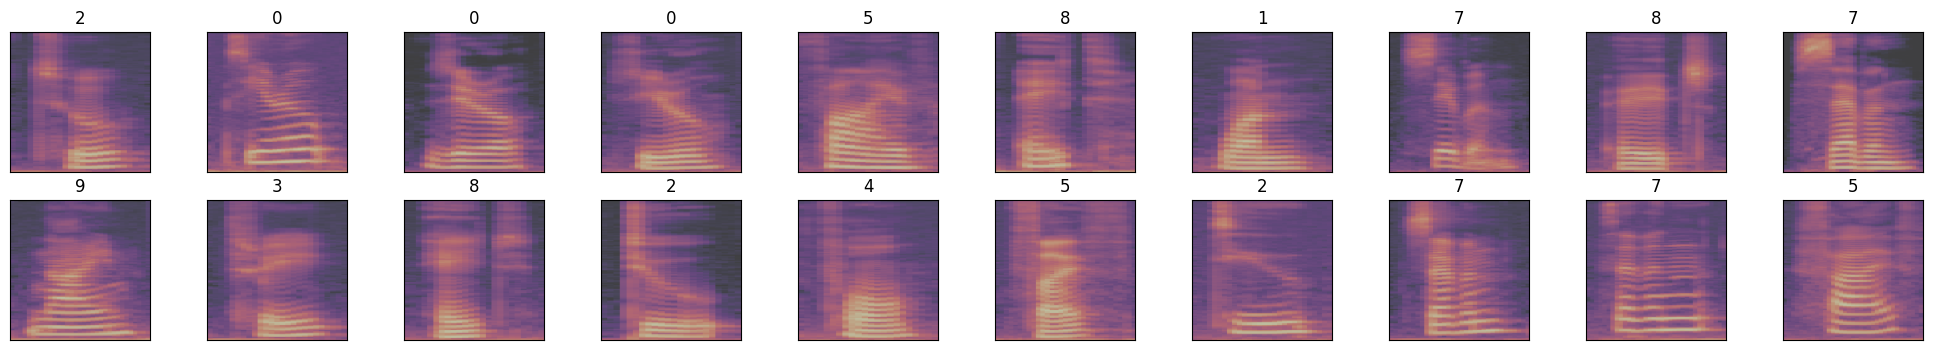

In [4]:
%matplotlib inline
classes = [str(i) for i in range(10)]  # If your classes are labeled 0 through 9
# Function to un-normalize and display an image
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize
    plt.imshow(img)  # No need to transpose

# Obtain one batch of training images
for images, labels in train_dataset.take(1):
    images = images.numpy()  # Convert images to numpy for display
    labels = labels.numpy()  # Convert labels to numpy for display

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

plt.show()

## The Model
We are going to use a simple CNN model to classify the spoken digits.
- Your are welcome to define your own model architecture.
- The baseline approach is to translate the following model from PyTorch to TensorFlow.
```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 5)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*53*53, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x
```

In [5]:
class Net(models.Model):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layer
        self.conv1 = layers.Conv2D(16, (5, 5), activation='relu', input_shape=(224, 224, 3))
        # Max pooling layer
        self.pool = layers.MaxPooling2D((2, 2))
        # Second convolutional layer
        self.conv2 = layers.Conv2D(32, (5, 5), activation='relu')
        # Dropout layer
        self.dropout = layers.Dropout(0.2)
        # Flatten layer
        self.flatten = layers.Flatten()
        # First fully connected layer
        self.fc1 = layers.Dense(256, activation='relu')
        # Second fully connected layer
        self.fc2 = layers.Dense(84, activation='relu')
        # Third fully connected layer (output layer)
        self.fc3 = layers.Dense(10)
        # Softmax activation function
        self.softmax = layers.Activation('softmax')

    def call(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

# Create the model instance
model = Net()

# Model summary to check the architecture
model.build((None, 224, 224, 3))  # `None` can accommodate a variable batch size
model.summary()

Model: "net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1216      
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  12832     
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  23011584  
                                                               

## Loss Function and Optimizer
One final step before we can simply call `model.fit`

In [6]:
# Loss function
loss_function = SparseCategoricalCrossentropy()

# Optimizer
optimizer = SGD(learning_rate=0.001, momentum=0.9)

# Compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

## Train!
Ideally the model should produce an Acc. of 96% or more.

In [7]:
# Training parameters
n_epochs = 2  # You may increase this number, but 2 epochs works well enough

# Callback for saving the best model in the TensorFlow SavedModel format
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('model_MNIST', save_best_only=True, save_format="tf")

# Fit the model
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=n_epochs,
                    callbacks=[checkpoint_cb])

Epoch 1/2


2024-02-07 18:29:55.435092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-02-07 18:29:55.460887: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


282/282 [==============================] - ETA: 0s - loss: 0.5038 - accuracy: 0.8392INFO:tensorflow:Assets written to: model_MNIST/assets


INFO:tensorflow:Assets written to: model_MNIST/assets


282/282 [==============================] - 53s 174ms/step - loss: 0.5038 - accuracy: 0.8392 - val_loss: 0.0954 - val_accuracy: 0.9698
Epoch 2/2
282/282 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9793INFO:tensorflow:Assets written to: model_MNIST/assets


INFO:tensorflow:Assets written to: model_MNIST/assets


282/282 [==============================] - 51s 181ms/step - loss: 0.0739 - accuracy: 0.9793 - val_loss: 0.0451 - val_accuracy: 0.9863


 ## Testing the CNN Model
 Evaluate the model on the test set

In [8]:
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f'Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy:.6f}')

94/94 [==============================] - 10s 101ms/step - loss: 0.0429 - accuracy: 0.9887
Test Loss: 0.042917, Test Accuracy: 0.988667


## Bonus Point:
- Try to report the acc of our model on different digits.
- Try to report a confusion matrix.

In [9]:
# Initialize lists to store predictions and labels
y_pred = []
y_true = []

# Iterate over the test dataset
for images, labels in test_dataset:
    # Make predictions
    predictions = model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1)
    
    # Extend the prediction and true labels lists
    y_pred.extend(predicted_classes.numpy())
    y_true.extend(labels.numpy())
print(classification_report(y_true, y_pred, target_names=classes))

2/2 [==============================] - 0s 27ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       600
           1       0.98      0.99      0.98       600
           2       0.99      0.98      0.99       600
           3       0.98      1.00      0.99       600
           4       0.98      0.99      0.99       600
           5       1.00      0.97      0.98       600
           6       0.99      0.99      0.99       600
           7       0.99      0.99      0.99       600
           8       0.99      0.99      0.99       600
           9       0.99      0.99      0.99       600

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



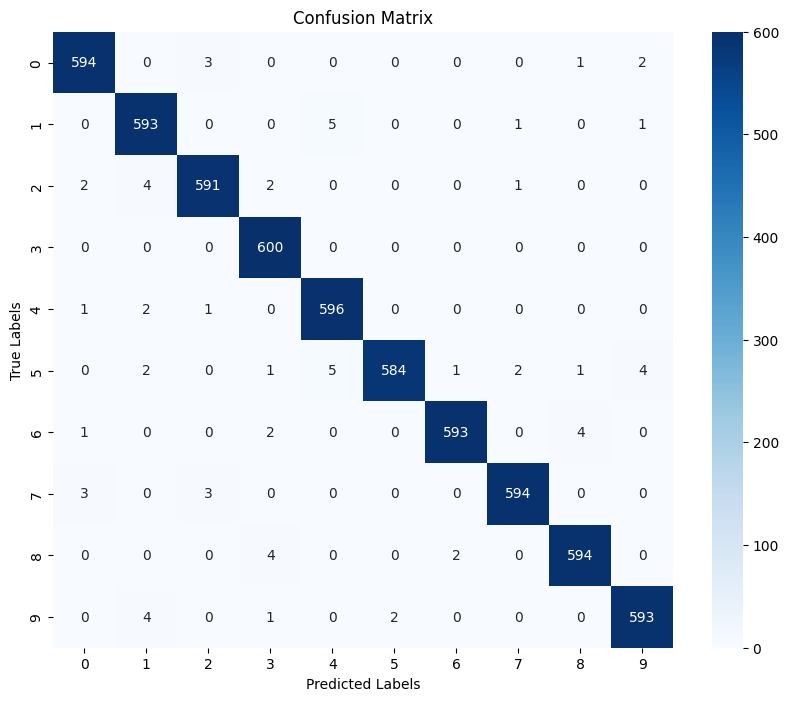

In [10]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()